# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [2]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder

In [4]:
df = pd.read_csv("/kaggle/input/british-airways-customer-booking/customer_booking.csv", encoding="ISO-8859-1")
df.head()

num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0               2      Internet  RoundTrip            262              19   
1               1      Internet  RoundTrip            112              20   
2               2      Internet  RoundTrip            243              22   
3               1      Internet  RoundTrip             96              31   
4               2      Internet  RoundTrip             68              22   

   flight_hour flight_day   route booking_origin  wants_extra_baggage  \
0            7        Sat  AKLDEL    New Zealand                    1   
1            3        Sat  AKLDEL    New Zealand                    0   
2           17        Wed  AKLDEL          India                    1   
3            4        Sat  AKLDEL    New Zealand                    0   
4           15        Wed  AKLDEL          India                    1   

   wants_preferred_seat  wants_in_flight_meals  flight_duration  \
0                     0                      0             5.52   
1                     0                      0             5.52   
2                     1                      0             5.52   
3                     0                      1             5.52   
4                     0                      1             5.52   

   booking_complete  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [6]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [7]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [8]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [9]:
df.describe()

num_passengers  purchase_lead  length_of_stay  flight_hour  \
count    50000.000000   50000.000000     50000.00000  50000.00000   
mean         1.591240      84.940480        23.04456      9.06634   
std          1.020165      90.451378        33.88767      5.41266   
min          1.000000       0.000000         0.00000      0.00000   
25%          1.000000      21.000000         5.00000      5.00000   
50%          1.000000      51.000000        17.00000      9.00000   
75%          2.000000     115.000000        28.00000     13.00000   
max          9.000000     867.000000       778.00000     23.00000   

         flight_day  wants_extra_baggage  wants_preferred_seat  \
count  50000.000000         50000.000000          50000.000000   
mean       3.814420             0.668780              0.296960   
std        1.992792             0.470657              0.456923   
min        1.000000             0.000000              0.000000   
25%        2.000000             0.000000              0.000000   
50%        4.000000             1.000000              0.000000   
75%        5.000000             1.000000              1.000000   
max        7.000000             1.000000              1.000000   

       wants_in_flight_meals  flight_duration  booking_complete  
count           50000.000000     50000.000000      50000.000000  
mean                0.427140         7.277561          0.149560  
std                 0.494668         1.496863          0.356643  
min                 0.000000         4.670000          0.000000  
25%                 0.000000         5.620000          0.000000  
50%                 0.000000         7.570000          0.000000  
75%                 1.000000         8.830000          0.000000  
max                 1.000000         9.500000          1.000000

The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [10]:
df["booking_complete"].unique()

array([0, 1])

In [11]:
df["booking_complete"].value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

In [12]:
#plt.plot(kind="bar", data=df["route"])
fig = px.pie(df, names="sales_channel", title="Percentages of Channels where Booking was made")
fig1 = px.pie(df, names="trip_type", title="Percentages of Type of Trip Chosen")
fig2 = px.pie(df, names="wants_extra_baggage", title="Percentages of Passengers who want extra Baggage")
fig3 = px.pie(df, names="booking_complete", title="Percentages of Booking Completeness")
fig.show()
fig1.show()
fig2.show()
fig3.show()

In [13]:
fig = px.bar(df["booking_origin"].value_counts().head(10), title="10 Most Frequent Places Where Booking is Done")
fig1 = px.bar(df["route"].value_counts().head(10), title="10 Most Frequent Routes")
fig2 = px.bar(
    x=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], 
    y=df["flight_day"].value_counts(), title="Flight Days"
)
fig.show()
fig1.show()
fig2.show()

In [14]:
df.corr()

num_passengers  purchase_lead  length_of_stay  \
num_passengers               1.000000       0.212606       -0.115850   
purchase_lead                0.212606       1.000000       -0.076560   
length_of_stay              -0.115850      -0.076560        1.000000   
flight_hour                  0.015607       0.035973       -0.024872   
flight_day                   0.015407       0.036531       -0.000310   
wants_extra_baggage          0.120404      -0.022207        0.176757   
wants_preferred_seat         0.028544      -0.004499        0.032264   
wants_in_flight_meals        0.022943      -0.022653        0.098828   
flight_duration             -0.063169       0.067866        0.141181   
booking_complete             0.024116      -0.022131       -0.042408   

                       flight_hour  flight_day  wants_extra_baggage  \
num_passengers            0.015607    0.015407             0.120404   
purchase_lead             0.035973    0.036531            -0.022207   
length_of_stay           -0.024872   -0.000310             0.176757   
flight_hour               1.000000    0.024086            -0.011434   
flight_day                0.024086    1.000000            -0.002503   
wants_extra_baggage      -0.011434   -0.002503             1.000000   
wants_preferred_seat      0.012171    0.005392             0.207669   
wants_in_flight_meals     0.013014    0.009281             0.216470   
flight_duration          -0.002101    0.018434             0.057054   
booking_complete          0.007127   -0.006986             0.068139   

                       wants_preferred_seat  wants_in_flight_meals  \
num_passengers                     0.028544               0.022943   
purchase_lead                     -0.004499              -0.022653   
length_of_stay                     0.032264               0.098828   
flight_hour                        0.012171               0.013014   
flight_day                         0.005392               0.009281   
wants_extra_baggage                0.207669               0.216470   
wants_preferred_seat               1.000000               0.315088   
wants_in_flight_meals              0.315088               1.000000   
flight_duration                    0.101289               0.154312   
booking_complete                   0.050116               0.026511   

                       flight_duration  booking_complete  
num_passengers               -0.063169          0.024116  
purchase_lead                 0.067866         -0.022131  
length_of_stay                0.141181         -0.042408  
flight_hour                  -0.002101          0.007127  
flight_day                    0.018434         -0.006986  
wants_extra_baggage           0.057054          0.068139  
wants_preferred_seat          0.101289          0.050116  
wants_in_flight_meals         0.154312          0.026511  
flight_duration               1.000000         -0.106266  
booking_complete             -0.106266          1.000000

In [15]:
df.head()

num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0               2      Internet  RoundTrip            262              19   
1               1      Internet  RoundTrip            112              20   
2               2      Internet  RoundTrip            243              22   
3               1      Internet  RoundTrip             96              31   
4               2      Internet  RoundTrip             68              22   

   flight_hour  flight_day   route booking_origin  wants_extra_baggage  \
0            7           6  AKLDEL    New Zealand                    1   
1            3           6  AKLDEL    New Zealand                    0   
2           17           3  AKLDEL          India                    1   
3            4           6  AKLDEL    New Zealand                    0   
4           15           3  AKLDEL          India                    1   

   wants_preferred_seat  wants_in_flight_meals  flight_duration  \
0                     0                      0             5.52   
1                     0                      0             5.52   
2                     1                      0             5.52   
3                     0                      1             5.52   
4                     0                      1             5.52   

   booking_complete  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

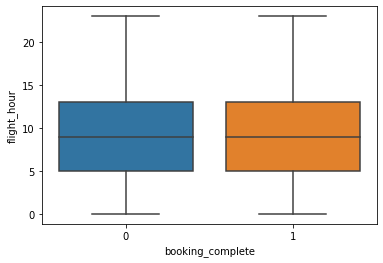

In [16]:
sns.boxplot(data=df, x="booking_complete", y="flight_hour");

Check for High and Low cardinality categorical features

In [17]:
df.select_dtypes("object").nunique()

sales_channel       2
trip_type           3
route             799
booking_origin    104
dtype: int64

**MODEL BUILDING**

In [18]:
target = "booking_complete"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (50000, 13)
y shape: (50000,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (40000, 13)
y_train shape: (40000,)
X_test shape: (10000, 13)
y_test shape: (10000,)


In [20]:
over_sampler = RandomOverSampler(random_state=42)

# oversampled training data for Gradient boost
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)

# oversampled training data for Random Forest
X_train_over_ranfor, y_train_over_ranfor = over_sampler.fit_resample(X_train, y_train)

X_train_over.shape

(68004, 13)

In [21]:
baseline_acc = y_train.value_counts(normalize=True).max()
print(f"Baseline Accuracy: {baseline_acc}")

Baseline Accuracy: 0.85005


In [22]:
# Gradient boost classifier
classifier = make_pipeline(OneHotEncoder(use_cat_names=True), GradientBoostingClassifier())

# Random forest classifier
classifier_ran_forest = make_pipeline(OneHotEncoder(use_cat_names=True), RandomForestClassifier(random_state=42))

In [23]:
# Gradient boosting parameters
parameters = {
    "gradientboostingclassifier__n_estimators": range(20, 31, 5),
    "gradientboostingclassifier__max_depth": range(2, 5)
}

# Random forest parameters
parameters_rand_forest = {
    "randomforestclassifier__n_estimators": range(25, 100, 25),
    "randomforestclassifier__max_depth": range(10, 50, 10)
}

In [24]:
#Gradient boosting model
model = GridSearchCV(
    classifier, 
    param_grid=parameters, 
    cv=5, 
    n_jobs=-1, 
    verbose=1
)

#Random Forest model
model_ran_forest = GridSearchCV(
    classifier_ran_forest, 
    parameters_rand_forest, 
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [25]:
# Train Gradient Boost training data
model.fit(X_train_over, y_train_over)

# Train Random Forest training data
model_ran_forest.fit(X_train_over_ranfor, y_train_over_ranfor)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25)},
             verbose=1)

In [26]:
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
8      42.579397      5.726272         0.472031        0.071131   
7      39.356111      0.406159         0.569204        0.018525   
6      31.575429      0.638256         0.616292        0.124560   
5      36.151000      0.452414         0.552860        0.008806   
4      30.579589      0.249596         0.597933        0.101315   

  param_gradientboostingclassifier__max_depth  \
8                                           4   
7                                           4   
6                                           4   
5                                           3   
4                                           3   

  param_gradientboostingclassifier__n_estimators  \
8                                             30   
7                                             25   
6                                             20   
5                                             30   
4                                             25   

                                              params  split0_test_score  \
8  {'gradientboostingclassifier__max_depth': 4, '...           0.707889   
7  {'gradientboostingclassifier__max_depth': 4, '...           0.706492   
6  {'gradientboostingclassifier__max_depth': 4, '...           0.700904   
5  {'gradientboostingclassifier__max_depth': 3, '...           0.698625   
4  {'gradientboostingclassifier__max_depth': 3, '...           0.690611   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
8           0.716638           0.706933           0.714580           0.721103   
7           0.713109           0.702301           0.713036           0.716397   
6           0.712668           0.698772           0.708183           0.713162   
5           0.703551           0.690537           0.701051           0.705368   
4           0.701640           0.689508           0.697449           0.702500   

   mean_test_score  std_test_score  rank_test_score  
8         0.713429        0.005355                1  
7         0.710267        0.005119                2  
6         0.706738        0.005933                3  
5         0.699827        0.005173                4  
4         0.696341        0.005418                5

In [27]:
results_ran_forest = pd.DataFrame(model_ran_forest.cv_results_)
results_ran_forest.sort_values("rank_test_score").head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
11      41.202934      6.296046         1.047738        0.177165   
10      31.802420      1.130901         0.950322        0.017563   
9       17.897953      0.231228         0.875947        0.185486   
8       36.956589      0.580026         1.177287        0.183470   
7       26.487366      0.234697         0.977064        0.146979   

   param_randomforestclassifier__max_depth  \
11                                      40   
10                                      40   
9                                       40   
8                                       30   
7                                       30   

   param_randomforestclassifier__n_estimators  \
11                                         75   
10                                         50   
9                                          25   
8                                          75   
7                                          50   

                                               params  split0_test_score  \
11  {'randomforestclassifier__max_depth': 40, 'ran...           0.868098   
10  {'randomforestclassifier__max_depth': 40, 'ran...           0.862142   
9   {'randomforestclassifier__max_depth': 40, 'ran...           0.858025   
8   {'randomforestclassifier__max_depth': 30, 'ran...           0.813470   
7   {'randomforestclassifier__max_depth': 30, 'ran...           0.810823   

    split1_test_score  split2_test_score  split3_test_score  \
11           0.864495           0.862437           0.874715   
10           0.865819           0.858834           0.873686   
9            0.860746           0.858981           0.873392   
8            0.815308           0.813764           0.821851   
7            0.814278           0.812220           0.818102   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
11           0.880368         0.870023        0.006646                1  
10           0.878382         0.867773        0.007252                2  
9            0.877353         0.865699        0.008044                3  
8            0.824632         0.817805        0.004568                4  
7            0.823382         0.815761        0.004532                5

In [28]:
model.best_params_

{'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__n_estimators': 30}

In [29]:
model_ran_forest.best_params_

{'randomforestclassifier__max_depth': 40,
 'randomforestclassifier__n_estimators': 75}

In [30]:
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print(f"Training accuracy: {train_accuracy}")
print(f"Validation accuracy: {test_accuracy}")

Training accuracy: 0.65265
Validation accuracy: 0.6464


In [31]:
train_accuracy_ran_forest = model_ran_forest.score(X_train, y_train)
test_accuracy_ran_forest = model_ran_forest.score(X_test, y_test)
print(f"Training accuracy: {train_accuracy_ran_forest}")
print(f"Validation accuracy: {test_accuracy_ran_forest}")

Training accuracy: 0.91425
Validation accuracy: 0.7814


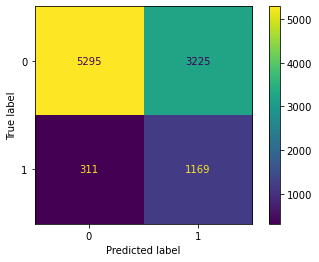

In [32]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);